In [1]:
import pickle
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix,
                             hamming_loss, roc_auc_score)
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("../Data/cleaned_data.csv")
df = df.iloc[:, 1:]

In [3]:
targets = [
  "6. Online Instructional Strategies/Assessment _Written assignment_",
  "6. Online Instructional Strategies/Assessment _Case Study_",
  "6. Online Instructional Strategies/Assessment _Real Time Online Exam_",
  "6. Online Instructional Strategies/Assessment _Individual Project/Assignment_",
  "6. Online Instructional Strategies/Assessment _Group Project/Assignment_",
  "6. Online Instructional Strategies/Assessment _Online Quiz/Test - MCQ_",
  "6. Online Instructional Strategies/Assessment _Online Quiz/Test - Essay_",
  "6. Online Instructional Strategies/Assessment _Online Quiz/Test - Open Book_",
  "6. Online Instructional Strategies/Assessment _Peer Review Assessment Live Presentation_",
  "6. Online Instructional Strategies/Assessment _Recorded Presentation_",
  "6. Online Instructional Strategies/Assessment _Portfolio_"
]

In [4]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

### Removing Columns
Due to the inconsistent formatting and assumed irrelevance of the columns, "Institutions", "Country", "Faculty", "Department", "Please share any comments or suggestions...", and "For technical or hands-on subject, ..." is removed before model training.

In [5]:
cols_to_drop = ["Institutions", "Country", "Faculty", "Department", "Please share any comments or suggestions related to this issue. Thank You"]
df.drop(df.columns[59], inplace=True, axis=1)
df.drop(cols_to_drop, inplace=True, axis=1)
df

,Gender,Level of Study,Field of study,Household Income,Learning Objects _Slide presentation_,Learning Objects _Book_,Learning Objects _Lecture Note_,Learning Objects _Educational game_,Learning Objects _Video_,Learning Objects _Audio-recorded lecture_,...,problem based learning,recorded,case study,demo,simulation,guided,forum,game,journaling,writing
0,0,2,0,2,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
1,0,2,0,2,4,4,4,4,3,2,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,3,3,4,4,3,4,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,3,1,4,2,3,3,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,4,1,4,3,3,3,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,0,1,0,2,3,1,3,4,4,3,...,0,0,0,0,0,0,0,0,0,0
310,0,1,0,1,3,3,4,3,3,2,...,0,0,0,1,0,0,0,0,0,0
311,1,1,0,2,2,3,2,3,3,3,...,0,0,0,0,0,0,0,0,0,0
312,0,1,0,1,3,3,4,3,4,4,...,0,0,0,0,0,0,0,0,0,0


# Inital Run of Models

### Train Test Split

In [6]:
X = df.loc[:, ~df.columns.isin(targets)]
y = df[targets]
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: (314, 165)
y.shape: (314, 11)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

### Model Training

In [8]:
def GBC(X_train, y_train, X_test, learning_rate):
  gbc = GradientBoostingClassifier(learning_rate=learning_rate, random_state=2024)
  model = MultiOutputClassifier(gbc).fit(X_train, y_train)
  prediction = model.predict(X_test)
  return model, prediction

In [9]:
def GNB(X_train, y_train, X_test):
  gnb = GaussianNB()
  model = MultiOutputClassifier(gnb).fit(X_train, y_train)
  prediction = model.predict(X_test)
  return model, prediction

In [10]:
def SVM(X_train, y_train, X_test):
  svc = SVC(random_state=2024)
  model = MultiOutputClassifier(svc).fit(X_train, y_train)
  prediction = model.predict(X_test)
  return model, prediction

In [11]:
def RFC(X_train, y_train, X_test):
  rfc = RandomForestClassifier(random_state=2024)
  model = MultiOutputClassifier(rfc).fit(X_train, y_train)
  prediction = model.predict(X_test)
  return model, prediction

In [12]:
def LR(X_train, y_train, X_test):
  lr = LogisticRegression(max_iter=1000, random_state=2024)
  model = MultiOutputClassifier(lr).fit(X_train, y_train)
  prediction = model.predict(X_test)
  return model, prediction

In [13]:
def XGB(X_train, y_train, X_test):
  classifier = MultiOutputClassifier(XGBClassifier(random_state=2024))
  clf = Pipeline([("classify", classifier)])
  clf.fit(X_train, y_train)
  prediction = clf.predict(X_test)
  return clf, prediction

In [14]:
gbc1, gbc_pred1 = GBC(X_train, y_train, X_test, 0.1)
gnb1, gnb_pred1 = GNB(X_train, y_train, X_test)
svm1, svm_pred1 = SVM(X_train, y_train, X_test)
rfc1, rfc_pred1 = RFC(X_train, y_train, X_test)
lr1, lr_pred1 = LR(X_train, y_train, X_test)
xgb1, xgb_pred1 = XGB(X_train, y_train, X_test)

### Model Evaluation

In [15]:
print("Hamming Loss of GBC1:", hamming_loss(y_test, gbc_pred1))
print("Hamming Loss of GNB1:", hamming_loss(y_test, gnb_pred1))
print("Hamming Loss of SVM1:", hamming_loss(y_test, svm_pred1))
print("Hamming Loss of RFC1:", hamming_loss(y_test, rfc_pred1))
print("Hamming Loss of LR1:", hamming_loss(y_test, lr_pred1))
print("Hamming Loss of XGB1:", hamming_loss(y_test, xgb_pred1))

Hamming Loss of GBC1: 0.24386724386724387
Hamming Loss of GNB1: 0.6060606060606061
Hamming Loss of SVM1: 0.23953823953823955
Hamming Loss of RFC1: 0.2222222222222222
Hamming Loss of LR1: 0.2741702741702742
Hamming Loss of XGB1: 0.24963924963924963


In [16]:
print("ROC AUC of GBC1:", roc_auc_score(y_test, gbc_pred1))
print("ROC AUC of GNB1:", roc_auc_score(y_test, gnb_pred1))
print("ROC AUC of SVM1:", roc_auc_score(y_test, svm_pred1))
print("ROC AUC of RFC1:", roc_auc_score(y_test, rfc_pred1))
print("ROC AUC of LR1:", roc_auc_score(y_test, lr_pred1))
print("ROC AUC of XGB1:", roc_auc_score(y_test, xgb_pred1))


ROC AUC of GBC1: 0.6729229965017972
ROC AUC of GNB1: 0.5003038891401707
ROC AUC of SVM1: 0.6330507336446574
ROC AUC of RFC1: 0.6915870686420313
ROC AUC of LR1: 0.6723753238171976
ROC AUC of XGB1: 0.6636351600999548


In [17]:
print(classification_report(y_test, gbc_pred1))

              precision    recall  f1-score   support

           0       0.80      0.75      0.78        44
           1       0.74      0.91      0.82        32
           2       0.67      0.73      0.70        33
           3       0.81      0.86      0.83        49
           4       0.79      0.82      0.80        45
           5       0.89      0.93      0.91        54
           6       0.78      0.72      0.75        39
           7       0.95      0.93      0.94        57
           8       0.78      0.88      0.83        43
           9       0.85      0.92      0.88        50
          10       0.74      0.80      0.77        35

   micro avg       0.81      0.85      0.83       481
   macro avg       0.80      0.84      0.82       481
weighted avg       0.81      0.85      0.83       481
 samples avg       0.76      0.79      0.75       481



c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
print(classification_report(y_test, gnb_pred1))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86        44
           1       0.43      0.09      0.15        32
           2       0.20      0.03      0.05        33
           3       0.62      0.10      0.18        49
           4       0.57      0.09      0.15        45
           5       0.82      0.17      0.28        54
           6       0.75      0.08      0.14        39
           7       0.78      0.12      0.21        57
           8       0.00      0.00      0.00        43
           9       0.75      0.12      0.21        50
          10       0.70      0.91      0.79        35

   micro avg       0.69      0.23      0.34       481
   macro avg       0.58      0.24      0.27       481
weighted avg       0.61      0.23      0.27       481
 samples avg       0.68      0.24      0.30       481



c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
print(classification_report(y_test, svm_pred1))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        44
           1       0.74      0.88      0.80        32
           2       0.65      0.79      0.71        33
           3       0.79      0.90      0.84        49
           4       0.73      0.82      0.77        45
           5       0.87      0.98      0.92        54
           6       0.79      0.77      0.78        39
           7       0.90      1.00      0.95        57
           8       0.79      0.88      0.84        43
           9       0.81      0.94      0.87        50
          10       0.72      0.80      0.76        35

   micro avg       0.80      0.88      0.84       481
   macro avg       0.79      0.87      0.83       481
weighted avg       0.80      0.88      0.84       481
 samples avg       0.76      0.84      0.76       481



c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
print(classification_report(y_test, rfc_pred1))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        44
           1       0.74      0.88      0.80        32
           2       0.69      0.82      0.75        33
           3       0.83      0.88      0.85        49
           4       0.77      0.82      0.80        45
           5       0.90      0.96      0.93        54
           6       0.81      0.74      0.77        39
           7       0.93      0.95      0.94        57
           8       0.84      0.88      0.86        43
           9       0.84      0.94      0.89        50
          10       0.74      0.83      0.78        35

   micro avg       0.82      0.86      0.84       481
   macro avg       0.82      0.86      0.83       481
weighted avg       0.83      0.86      0.84       481
 samples avg       0.77      0.81      0.76       481



c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
print(classification_report(y_test, lr_pred1))

              precision    recall  f1-score   support

           0       0.79      0.70      0.75        44
           1       0.72      0.91      0.81        32
           2       0.67      0.67      0.67        33
           3       0.85      0.84      0.85        49
           4       0.77      0.76      0.76        45
           5       0.93      0.94      0.94        54
           6       0.75      0.77      0.76        39
           7       0.94      0.88      0.91        57
           8       0.83      0.70      0.76        43
           9       0.81      0.68      0.74        50
          10       0.76      0.71      0.74        35

   micro avg       0.81      0.78      0.80       481
   macro avg       0.80      0.78      0.79       481
weighted avg       0.82      0.78      0.80       481
 samples avg       0.77      0.72      0.71       481



c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
print(classification_report(y_test, xgb_pred1))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77        44
           1       0.74      0.91      0.82        32
           2       0.65      0.67      0.66        33
           3       0.80      0.92      0.86        49
           4       0.74      0.87      0.80        45
           5       0.89      0.94      0.92        54
           6       0.80      0.82      0.81        39
           7       0.95      0.93      0.94        57
           8       0.77      0.84      0.80        43
           9       0.86      0.84      0.85        50
          10       0.72      0.74      0.73        35

   micro avg       0.80      0.85      0.82       481
   macro avg       0.79      0.84      0.81       481
weighted avg       0.81      0.85      0.82       481
 samples avg       0.74      0.78      0.74       481



c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print("Accuracy of GBC1:", accuracy_score(y_test, gbc_pred1))
print("Accuracy of GNB1:", accuracy_score(y_test, gnb_pred1))
print("Accuracy of SVM1:", accuracy_score(y_test, svm_pred1))
print("Accuracy of RFC1:", accuracy_score(y_test, rfc_pred1))
print("Accuracy of LR1:", accuracy_score(y_test, lr_pred1))
print("Accuracy of XGB1:", accuracy_score(y_test, xgb_pred1))

Accuracy of GBC1: 0.23809523809523808
Accuracy of GNB1: 0.031746031746031744
Accuracy of SVM1: 0.1746031746031746
Accuracy of RFC1: 0.23809523809523808
Accuracy of LR1: 0.15873015873015872
Accuracy of XGB1: 0.25396825396825395


In [24]:
y_test_df = pd.DataFrame(y_test)

In [25]:
def accuracy_std(pred):
  pred1_df = pd.DataFrame(pred)
  accuracy = []
  for i in range(len(y_test.columns)):
    accuracy.append(accuracy_score(y_test_df.iloc[:, i], pred1_df.iloc[:, i]))
  print(f"Standard Deviation of Accuracies: {np.std(accuracy)}")

In [26]:
accuracy_std(gbc_pred1)
accuracy_std(gnb_pred1)
accuracy_std(svm_pred1)
accuracy_std(rfc_pred1)
accuracy_std(lr_pred1)
accuracy_std(xgb_pred1)

Standard Deviation of Accuracies: 0.06536653190710606
Standard Deviation of Accuracies: 0.19461804916896133
Standard Deviation of Accuracies: 0.07177391120026486
Standard Deviation of Accuracies: 0.05900446839902128
Standard Deviation of Accuracies: 0.07953543307082638
Standard Deviation of Accuracies: 0.0722942282821088


## More Data Cleaning
The performance of the models are nowhere near satisfactory. Hence, I will proceed to do more data cleaning.  
**The cleaning below is done while referring to report2.html*

### _prefsocmed
Below are the columns which are very imbalanced due to one hot encoding. The approach is to group similar columns.
- Discord_prefsocmed
- WhatsApp_prefsocmed
- Whatapp_prefsocmed
- zoom_prefsocmed
- Webex_prefsocmed
- google meet_prefsocmed
- Google meet _prefsocmed
- Google Meet_prefsocmed
- Microsoft Team_prefsocmed
- Msteam_prefsocmed
- Microsoft Teams_prefsocmed
- Google Classroom_prefsocmed
- Google Classroom _prefsocmed
- Google classroom_prefsocmed
- Reddit_prefsocmed
- Blogger/Wordpress_prefsocmed
- Forums_prefsocmed
- TIKTOK_prefsocmed
- Tiktok_prefsocmed
- YouTube _prefsocmed
- Telegram_prefsocmed
- Telegram and Google Classroom_prefsocmed
- LinkedIn_prefsocmed

In [27]:
similar_socmed = [
  ["WhatsApp_prefsocmed", "Whatapp_prefsocmed"],
  ["zoom_prefsocmed", "Webex_prefsocmed", "google meet_prefsocmed", "Google meet _prefsocmed", "Google Meet_prefsocmed"],
  ["Microsoft Teams_prefsocmed", "Msteam_prefsocmed", "Microsoft Team_prefsocmed"],
  ["Google Classroom_prefsocmed", "Google Classroom _prefsocmed", "Google classroom_prefsocmed"],
  ["TIKTOK_prefsocmed", "Tiktok_prefsocmed"], 
  ["Reddit_prefsocmed", "Blogger/Wordpress_prefsocmed", "Forums_prefsocmed"],
  ["YouTube _prefsocmed", "Youtube_prefsocmed"]
]

Some of the columns are ignored as they don't belong to a particular similar group and the data is too few to be significant.

In [28]:
for socmed in similar_socmed:
  first_column = socmed[0]
  df[first_column] = df[socmed].max(axis=1)

In [29]:
for socmed in similar_socmed:
  socmed = socmed[1:]
  df.drop(socmed, inplace=True, axis="columns")

In [30]:
other_columns = ["Discord_prefsocmed", "Telegram_prefsocmed", "Telegram and Google Classroom_prefsocmed", "LinkedIn_prefsocmed"]

In [31]:
df.drop(other_columns, inplace=True, axis="columns")

### _prefcomm
Below are the columns which are very imbalanced due to one hot encoding. The approach to clean this subset of data is similar to those in _prefsocmed.
- Telegram_prefcomm
- telegram_prefcomm
- Zoom_prefcomm
- Google Meet_prefcomm
- Google meet_prefcomm
- Google Meet _prefcomm
- Google meet _prefcomm
- Cisco Webex_prefcomm
- MS Team_prefcomm
- Microsoft Teams_prefcomm
- Google Classroom _prefcomm
- Google Classroom_prefcomm
- Kaizala_prefcomm
- Discord_prefcomm

In [32]:
similar_comm = [
  ["Telegram_prefcomm", "telegram_prefcomm"], 
  ["Zoom_prefcomm", "Google meet_prefcomm", "Google Meet _prefcomm", "Google Meet_prefcomm", "Google meet _prefcomm", "Cisco Webex_prefcomm"], 
  ["MS Team_prefcomm", "Microsoft Teams_prefcomm"], 
  ["Google Classroom _prefcomm", "Google Classroom_prefcomm"]
]
comm_to_rm = ["Kaizala_prefcomm", "Discord_prefcomm"]

In [33]:
for comm in similar_comm:
  first_column = comm[0]
  df[first_column] = df[comm].max(axis=1)

In [34]:
for comm in similar_comm:
  comm = comm[1:]
  df.drop(comm, inplace=True, axis="columns")
df.drop(comm_to_rm, inplace=True, axis="columns")

### _onlinelearningdifficulties
Below are the columns related to online learning difficulties:
- Accessibility_onlinelearningdifficulties
- I've always had a terrible attention span even in f2f classes_onlinelearningdifficulties
- Not sure_onlinelearningdifficulties
- Line connection_onlinelearningdifficulties
- Quality of Material_onlinelearningdifficulties
- Adaptability_onlinelearningdifficulties
- no actual study space at home so have to study on the bed_onlinelearningdifficulties
- Health Issues_onlinelearningdifficulties
- its just that there is no feeling T_T_onlinelearningdifficulties
- University lack of student well-being management_onlinelearningdifficulties
- Focus/Commitment_onlinelearningdifficulties
- No_onlinelearningdifficulties
- Not enough data _onlinelearningdifficulties
- Time Management_onlinelearningdifficulties
- Cost_onlinelearningdifficulties
- ie: family conflicts_onlinelearningdifficulties
- Technical Issues_onlinelearningdifficulties
- Engagement_onlinelearningdifficulties
- External factors_onlinelearningdifficulties
- I cannot study well using online_onlinelearningdifficulties
- Self-Motivation_onlinelearningdifficulties
- Computer Literacy_onlinelearningdifficulties
- Cost/Focus/Commitment_onlinelearningdifficulties
- None_onlinelearningdifficulties

"Not sure", "No", "Not enough data", and "None" will be removed. While the others will be grouped based on their similarities in nature.  

I have identified the columns below to be the main groups of online learning difficulties, the other columns will be grouped based on them: 
- Accessibility_onlinelearningdifficulties
- Quality of Material_onlinelearningdifficulties
- Adaptability_onlinelearningdifficulties
- Health Issues_onlinelearningdifficulties
- Focus/Commitment_onlinelearningdifficulties
- Time Management_onlinelearningdifficulties
- Cost_onlinelearningdifficulties
- Technical Issues_onlinelearningdifficulties
- Engagement_onlinelearningdifficulties
- Self-Motivation_onlinelearningdifficulties

In [35]:
difficulties_group = [
  ["Adaptability_onlinelearningdifficulties", 
   "I've always had a terrible attention span even in f2f classes_onlinelearningdifficulties", 
   "University lack of student well-being management_onlinelearningdifficulties",
   "External factors_onlinelearningdifficulties", 
   "I cannot study well using online_onlinelearningdifficulties"], 
  ["Technical Issues_onlinelearningdifficulties", 
   "Line connection_onlinelearningdifficulties", 
   "Computer Literacy_onlinelearningdifficulties"],
  ["Engagement_onlinelearningdifficulties", 
   "no actual study space at home so have to study on the bed_onlinelearningdifficulties"], 
  ["Self-Motivation_onlinelearningdifficulties", 
   "its just that there is no feeling T_T_onlinelearningdifficulties"],
  ["Focus/Commitment_onlinelearningdifficulties", 
   "ie: family conflicts_onlinelearningdifficulties", 
   "Cost/Focus/Commitment_onlinelearningdifficulties"],
  ["Cost_onlinelearningdifficulties", "Cost/Focus/Commitment_onlinelearningdifficulties"]
]
difficulties_to_rm = ["No_onlinelearningdifficulties", 
                      "Not enough data _onlinelearningdifficulties", 
                      "Not sure_onlinelearningdifficulties", 
                      "None_onlinelearningdifficulties"]

In [36]:
for difficulties in difficulties_group:
  first_column = difficulties[0]
  df[first_column] = df[difficulties].max(axis=1)

In [37]:
for difficulties in difficulties_group[:-1]:
  difficulties = difficulties[1:]
  df.drop(difficulties, inplace=True, axis="columns")
df.drop(difficulties_to_rm, inplace=True, axis="columns")

In [38]:
df.shape

(314, 135)

### Online Instructional Strategies/Assessment Grouping
Some of these newly derived columns have very imbalanced data (i.e. only few rows contain the value '1', while others '0'). To tackle this, these imbalanced columns (contains more than 90% of zeros) will be grouped into a new 'others' column. These columns are: 
- debugging
- problem based learning
- case study
- demo
- simulation
- guided
- forum
- game
- journaling
- writing

In [39]:
online_assessment_columns = ["debugging", "problem based learning", "case study", "demo", "simulation", "guided", "forum", "game", "journaling", "writing"]
sub_df = df[online_assessment_columns]
sub_df

,debugging,problem based learning,case study,demo,simulation,guided,forum,game,journaling,writing
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
309,1,0,0,0,0,0,0,0,0,0
310,0,0,0,1,0,0,0,0,0,0
311,0,0,0,0,0,0,0,0,0,0
312,0,0,0,0,0,0,0,0,0,0


In [40]:
sub_df["others"] = sub_df.values.argmax(1)
sub_df

C:\Users\limzh\AppData\Local\Temp\ipykernel_20924\325570515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["others"] = sub_df.values.argmax(1)


,debugging,problem based learning,case study,demo,simulation,guided,forum,game,journaling,writing,others
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
309,1,0,0,0,0,0,0,0,0,0,0
310,0,0,0,1,0,0,0,0,0,0,3
311,0,0,0,0,0,0,0,0,0,0,0
312,0,0,0,0,0,0,0,0,0,0,0


In [41]:
sub_df["others"] = np.where(sub_df["others"] > 0, 1, 0)
sub_df

C:\Users\limzh\AppData\Local\Temp\ipykernel_20924\2533732910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["others"] = np.where(sub_df["others"] > 0, 1, 0)


,debugging,problem based learning,case study,demo,simulation,guided,forum,game,journaling,writing,others
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
309,1,0,0,0,0,0,0,0,0,0,0
310,0,0,0,1,0,0,0,0,0,0,1
311,0,0,0,0,0,0,0,0,0,0,0
312,0,0,0,0,0,0,0,0,0,0,0


In [42]:
sub_df = sub_df["others"]
df.drop(online_assessment_columns, inplace=True, axis="columns")

In [43]:
df = df.merge(sub_df.to_frame(), left_index=True, right_index=True)

In [44]:
# report3 = ProfileReport(df, title="Re-clean", minimal=True, html={"style": {"full_width": True}})
# report3.to_file("report3.html")

# Second Run of Models

In [45]:
X2 = df.loc[:, ~df.columns.isin(targets)]
y2 = df[targets]
print(f"X2.shape: {X2.shape}")
print(f"y2.shape: {y2.shape}")

X2.shape: (314, 115)
y2.shape: (314, 11)


In [46]:
for i in X2.columns.to_list():
  print(i)

Gender
Level of Study
Field of study
Household Income
Learning Objects _Slide presentation_
Learning Objects _Book_
Learning Objects _Lecture Note_
Learning Objects _Educational game_
Learning Objects _Video_
Learning Objects _Audio-recorded lecture_
Learning Objects _Animated instruction_
Learning Objects _Real object model_
Learning Objects _Mind Map_
Learning Objects _Multimedia content_
Learning Objects _Interactive Tool_
Learning Objects _Technology-supported learning include computer-based training systems_
Learning Objects _Intelligent computer-aided instruction systems_
6. Online Instructional Strategies/Assessment _Live Lecture_
6. Online Instructional Strategies/Assessment _Pre-Recorded Lecture_
6. Online Instructional Strategies/Assessment _Pre-Recorded Slide Lecture_
6. Online Instructional Strategies/Assessment _Demonstration_
6. Online Instructional Strategies/Assessment _Simulation_
6. Online Instructional Strategies/Assessment _Guided Learning (Hands on)_
6. Online Inst

In [47]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=2024)

In [48]:
gbc2, gbc_pred2 = GBC(X2_train, y2_train, X2_test, 0.1)
gnb2, gnb_pred2 = GNB(X2_train, y2_train, X2_test)
svm2, svm_pred2 = SVM(X2_train, y2_train, X2_test)
rfc2, rfc_pred2 = RFC(X2_train, y2_train, X2_test)
lr2, lr_pred2 = LR(X2_train, y2_train, X2_test)
xgb2, xgb_pred2 = XGB(X2_train, y2_train, X2_test)

In [49]:
print("Hamming Loss of GBC2:", hamming_loss(y2_test, gbc_pred2))
print("Hamming Loss of GNB2:", hamming_loss(y2_test, gnb_pred2))
print("Hamming Loss of SVM2:", hamming_loss(y2_test, svm_pred2))
print("Hamming Loss of RFC2:", hamming_loss(y2_test, rfc_pred2))
print("Hamming Loss of LR2:", hamming_loss(y2_test, lr_pred2))
print("Hamming Loss of XGB2:", hamming_loss(y2_test, xgb_pred2))

Hamming Loss of GBC2: 0.227994227994228
Hamming Loss of GNB2: 0.5526695526695526
Hamming Loss of SVM2: 0.24242424242424243
Hamming Loss of RFC2: 0.22655122655122656
Hamming Loss of LR2: 0.2756132756132756
Hamming Loss of XGB2: 0.2582972582972583


In [50]:
print("ROC AUC Score of GBC2:", roc_auc_score(y_test, gbc_pred2))
print("ROC AUC Score of GNB2:", roc_auc_score(y_test, gnb_pred2))
print("ROC AUC Score of SVM2:", roc_auc_score(y_test, svm_pred2))
print("ROC AUC Score of RFC2:", roc_auc_score(y_test, rfc_pred2))
print("ROC AUC Score of LR2:", roc_auc_score(y_test, lr_pred2))
print("ROC AUC Score of XGB2:", roc_auc_score(y_test, xgb_pred2))

ROC AUC Score of GBC2: 0.6925418313525156
ROC AUC Score of GNB2: 0.5763988854284541
ROC AUC Score of SVM2: 0.6357805352668362
ROC AUC Score of RFC2: 0.6872497336676352
ROC AUC Score of LR2: 0.6687280518877144
ROC AUC Score of XGB2: 0.6553262424429401


In [51]:
print(classification_report(y2_test, gbc_pred2))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        44
           1       0.77      0.94      0.85        32
           2       0.69      0.67      0.68        33
           3       0.81      0.88      0.84        49
           4       0.78      0.87      0.82        45
           5       0.93      0.93      0.93        54
           6       0.78      0.72      0.75        39
           7       0.93      0.93      0.93        57
           8       0.80      0.84      0.82        43
           9       0.85      0.90      0.87        50
          10       0.81      0.83      0.82        35

   micro avg       0.83      0.85      0.84       481
   macro avg       0.82      0.84      0.83       481
weighted avg       0.83      0.85      0.84       481
 samples avg       0.77      0.79      0.76       481



c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
print(classification_report(y2_test, gnb_pred2))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82        44
           1       0.67      0.12      0.21        32
           2       0.75      0.09      0.16        33
           3       1.00      0.08      0.15        49
           4       0.67      0.04      0.08        45
           5       1.00      0.13      0.23        54
           6       0.72      0.87      0.79        39
           7       0.83      0.09      0.16        57
           8       0.80      0.09      0.17        43
           9       0.83      0.10      0.18        50
          10       0.77      0.86      0.81        35

   micro avg       0.80      0.27      0.41       481
   macro avg       0.81      0.30      0.34       481
weighted avg       0.82      0.27      0.32       481
 samples avg       0.61      0.24      0.32       481



c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
print(classification_report(y2_test, svm_pred2))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        44
           1       0.72      0.88      0.79        32
           2       0.69      0.82      0.75        33
           3       0.81      0.86      0.83        49
           4       0.73      0.82      0.77        45
           5       0.87      0.96      0.91        54
           6       0.77      0.77      0.77        39
           7       0.90      1.00      0.95        57
           8       0.78      0.84      0.81        43
           9       0.81      0.94      0.87        50
          10       0.72      0.80      0.76        35

   micro avg       0.80      0.87      0.83       481
   macro avg       0.79      0.86      0.82       481
weighted avg       0.80      0.87      0.83       481
 samples avg       0.76      0.82      0.75       481



c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
print(classification_report(y2_test, rfc_pred2))

              precision    recall  f1-score   support

           0       0.87      0.75      0.80        44
           1       0.74      0.91      0.82        32
           2       0.67      0.79      0.72        33
           3       0.79      0.86      0.82        49
           4       0.78      0.87      0.82        45
           5       0.91      0.94      0.93        54
           6       0.83      0.74      0.78        39
           7       0.93      0.96      0.95        57
           8       0.86      0.86      0.86        43
           9       0.84      0.94      0.89        50
          10       0.71      0.77      0.74        35

   micro avg       0.82      0.86      0.84       481
   macro avg       0.81      0.85      0.83       481
weighted avg       0.82      0.86      0.84       481
 samples avg       0.77      0.80      0.76       481



c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
print(classification_report(y2_test, lr_pred2))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        44
           1       0.72      0.88      0.79        32
           2       0.68      0.70      0.69        33
           3       0.86      0.86      0.86        49
           4       0.77      0.76      0.76        45
           5       0.93      0.94      0.94        54
           6       0.74      0.74      0.74        39
           7       0.94      0.88      0.91        57
           8       0.81      0.70      0.75        43
           9       0.81      0.68      0.74        50
          10       0.76      0.74      0.75        35

   micro avg       0.81      0.79      0.80       481
   macro avg       0.80      0.78      0.79       481
weighted avg       0.81      0.79      0.80       481
 samples avg       0.77      0.72      0.71       481



c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
print(classification_report(y2_test, xgb_pred2))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        44
           1       0.72      0.91      0.81        32
           2       0.65      0.73      0.69        33
           3       0.81      0.86      0.83        49
           4       0.74      0.87      0.80        45
           5       0.89      0.94      0.92        54
           6       0.81      0.77      0.79        39
           7       0.95      0.95      0.95        57
           8       0.79      0.86      0.82        43
           9       0.84      0.84      0.84        50
          10       0.69      0.71      0.70        35

   micro avg       0.80      0.84      0.82       481
   macro avg       0.79      0.83      0.81       481
weighted avg       0.80      0.84      0.82       481
 samples avg       0.73      0.78      0.74       481



c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\limzh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
print("Accuracy of GBC2:", accuracy_score(y2_test, gbc_pred2))
print("Accuracy of GNB2:", accuracy_score(y2_test, gnb_pred2))
print("Accuracy of SVM2:", accuracy_score(y2_test, svm_pred2))
print("Accuracy of RFC2:", accuracy_score(y2_test, rfc_pred2))
print("Accuracy of LR2:", accuracy_score(y2_test, lr_pred2))
print("Accuracy of XGB2:", accuracy_score(y2_test, xgb_pred2))

Accuracy of GBC2: 0.23809523809523808
Accuracy of GNB2: 0.047619047619047616
Accuracy of SVM2: 0.20634920634920634
Accuracy of RFC2: 0.23809523809523808
Accuracy of LR2: 0.15873015873015872
Accuracy of XGB2: 0.25396825396825395


In [58]:
y2_test_df = pd.DataFrame(y2_test)

In [59]:
accuracy_std(gbc_pred2)
accuracy_std(gnb_pred2)
accuracy_std(svm_pred2)
accuracy_std(rfc_pred2)
accuracy_std(lr_pred2)
accuracy_std(xgb_pred2)

Standard Deviation of Accuracies: 0.06359037384280146
Standard Deviation of Accuracies: 0.21218500871388352
Standard Deviation of Accuracies: 0.06669102457888221
Standard Deviation of Accuracies: 0.06805094443031225
Standard Deviation of Accuracies: 0.08073074014833688
Standard Deviation of Accuracies: 0.07808224680212804


In [85]:
gbc_pred2

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 1, 1, 1, 1,

In [86]:
list(X2_train.iloc[6, :])

[0,
 1,
 0,
 0,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 4,
 4,
 3,
 3,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 3,
 3,
 4,
 4,
 3,
 4,
 4,
 3,
 4,
 2,
 4,
 3,
 2,
 4,
 1,
 1,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0]

## Cross Validation with GBC2, RFC2, and XGB2

In [61]:
metrics = ["roc_auc", "f1_macro", "precision_macro", "recall_macro", "accuracy"]
gbc2_scores = cross_validate(gbc2, X, y, cv=5, scoring=metrics)
rfc2_scores = cross_validate(rfc2, X, y, cv=5, scoring=metrics)
xgb2_scores = cross_validate(xgb2, X, y, cv=5, scoring=metrics)

In [62]:
def visualize_score(score, title):
  i = list(range(5))
  plt.bar(i, score)
  plt.title(title)
  plt.show()

In [63]:
gbc2_scores

{'fit_time': array([8.00708055, 4.43666029, 4.3250041 , 3.97532034, 5.12619591]),
 'score_time': array([0.13869429, 0.12762618, 0.1409862 , 0.1431675 , 0.13966584]),
 'test_roc_auc': array([0.69515383, 0.79187803, 0.78520953, 0.74825618, 0.70776351]),
 'test_f1_macro': array([0.77885091, 0.79611279, 0.79365512, 0.81858197, 0.72594481]),
 'test_precision_macro': array([0.7389144 , 0.7606299 , 0.77267914, 0.78218175, 0.7177935 ]),
 'test_recall_macro': array([0.82574348, 0.84176394, 0.82438342, 0.86062962, 0.7386375 ]),
 'test_accuracy': array([0.15873016, 0.17460317, 0.19047619, 0.19047619, 0.08064516])}

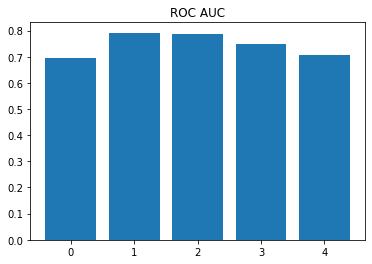

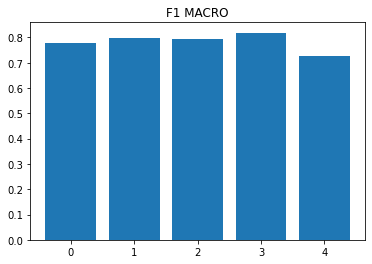

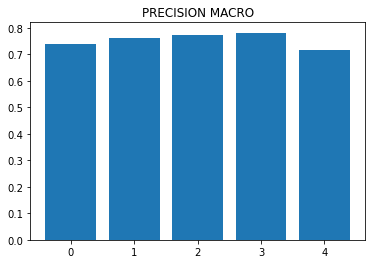

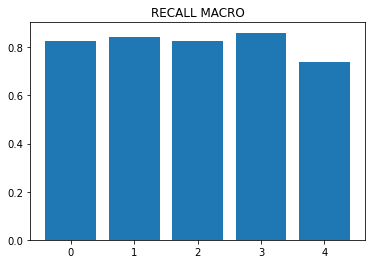

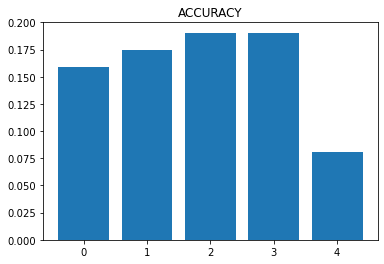

In [64]:
visualize_score(gbc2_scores["test_roc_auc"], "ROC AUC")
visualize_score(gbc2_scores["test_f1_macro"], "F1 MACRO")
visualize_score(gbc2_scores["test_precision_macro"], "PRECISION MACRO")
visualize_score(gbc2_scores["test_recall_macro"], "RECALL MACRO")
visualize_score(gbc2_scores["test_accuracy"], "ACCURACY")

In [65]:
rfc2_scores

{'fit_time': array([3.82319784, 6.59823322, 6.10019445, 6.27041411, 6.04601765]),
 'score_time': array([0.79398179, 1.1963048 , 0.59698749, 0.84385133, 1.01888776]),
 'test_roc_auc': array([0.73335801, 0.82512335, 0.82624929, 0.799711  , 0.73523143]),
 'test_f1_macro': array([0.78496268, 0.83674672, 0.80995447, 0.8337291 , 0.72166297]),
 'test_precision_macro': array([0.72428814, 0.78093439, 0.78898483, 0.77124677, 0.71976393]),
 'test_recall_macro': array([0.86354027, 0.90382138, 0.83959349, 0.91019839, 0.73234167]),
 'test_accuracy': array([0.17460317, 0.31746032, 0.25396825, 0.25396825, 0.08064516])}

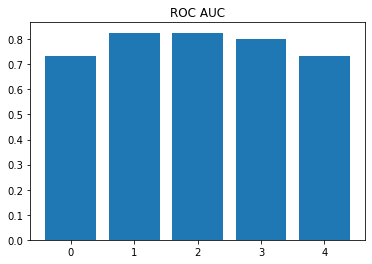

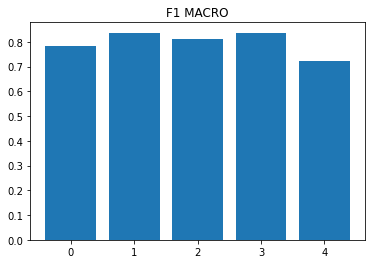

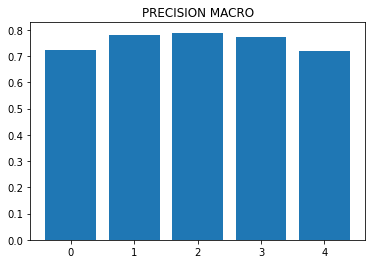

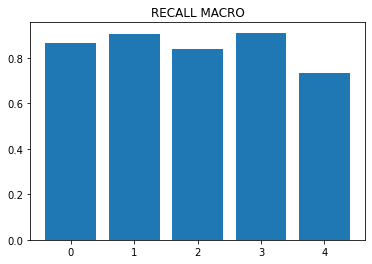

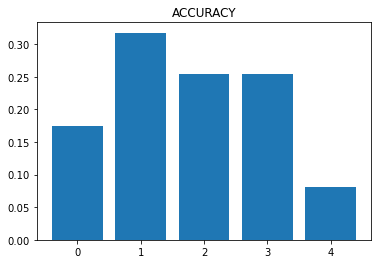

In [66]:
visualize_score(rfc2_scores["test_roc_auc"], "ROC AUC")
visualize_score(rfc2_scores["test_f1_macro"], "F1 MACRO")
visualize_score(rfc2_scores["test_precision_macro"], "PRECISION MACRO")
visualize_score(rfc2_scores["test_recall_macro"], "RECALL MACRO")
visualize_score(rfc2_scores["test_accuracy"], "ACCURACY")

In [67]:
xgb2_scores

{'fit_time': array([6.15892982, 4.13760495, 6.10640883, 6.76051807, 6.1680162 ]),
 'score_time': array([2.23942065, 1.67919588, 2.26261163, 1.96548247, 1.99703622]),
 'test_roc_auc': array([0.7235932 , 0.81230666, 0.7941492 , 0.74857846, 0.70657076]),
 'test_f1_macro': array([0.77757399, 0.80155813, 0.80532999, 0.82359897, 0.73437875]),
 'test_precision_macro': array([0.73662509, 0.76343549, 0.78783439, 0.77576538, 0.72935031]),
 'test_recall_macro': array([0.82822724, 0.8496074 , 0.83126779, 0.8801319 , 0.74325441]),
 'test_accuracy': array([0.12698413, 0.28571429, 0.22222222, 0.22222222, 0.08064516])}

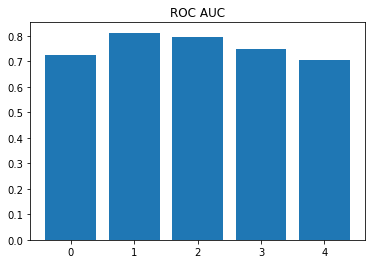

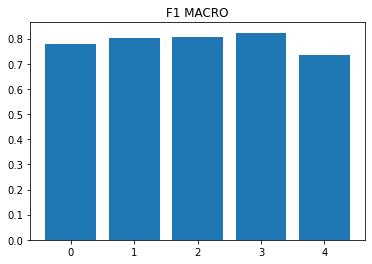

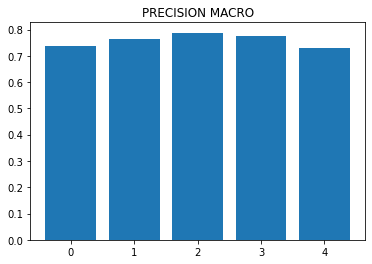

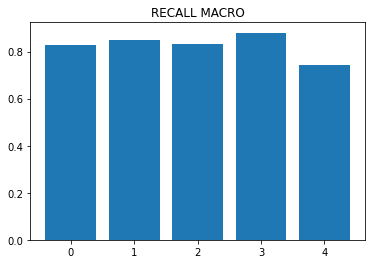

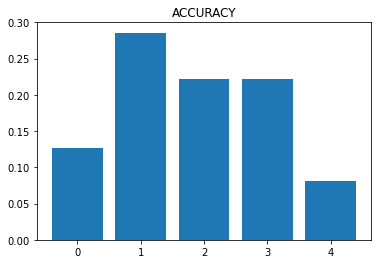

In [68]:
visualize_score(xgb2_scores["test_roc_auc"], "ROC AUC")
visualize_score(xgb2_scores["test_f1_macro"], "F1 MACRO")
visualize_score(xgb2_scores["test_precision_macro"], "PRECISION MACRO")
visualize_score(xgb2_scores["test_recall_macro"], "RECALL MACRO")
visualize_score(xgb2_scores["test_accuracy"], "ACCURACY")

## Confusion Matrices of GBC2, RFC2, and XGB2

In [69]:
def disp_multilabel_cm(pred, x, y):
  fig, ax = plt.subplots(x, y, figsize=(25, 15))
  ax = ax.ravel()
  for i in range(x*y):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.iloc[:, i], pred[:, i]))
    disp.plot(ax=ax[i])
    disp.ax_.set_title(f"Class {i}")
    if i < 8:
        disp.ax_.set_xlabel('')
    if i % 4 != 0:
        disp.ax_.set_ylabel('')
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

IndexError: single positional indexer is out-of-bounds

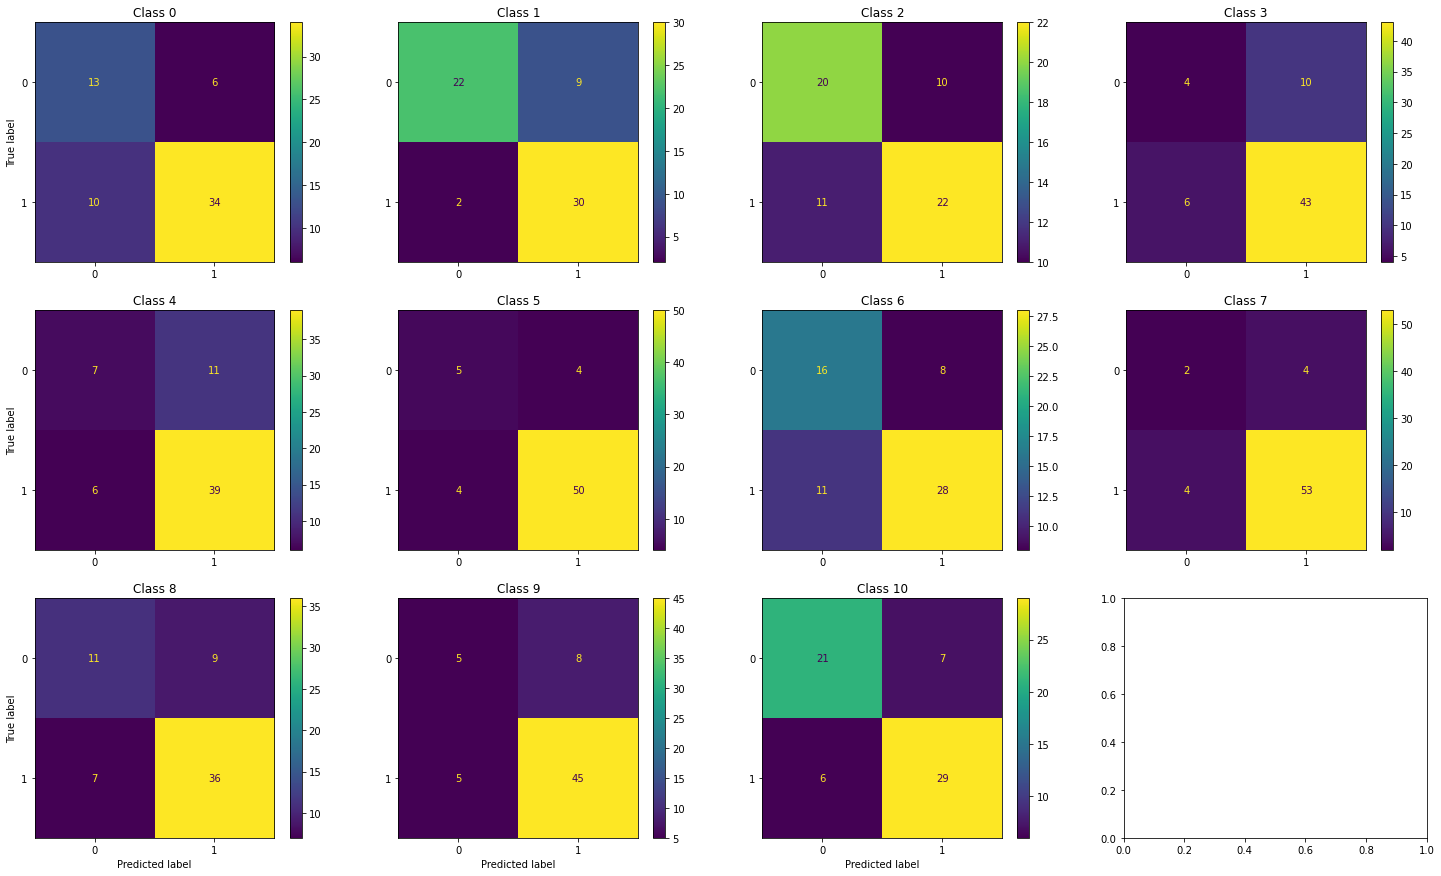

In [70]:
disp_multilabel_cm(gbc_pred2, 3, 4)

IndexError: single positional indexer is out-of-bounds

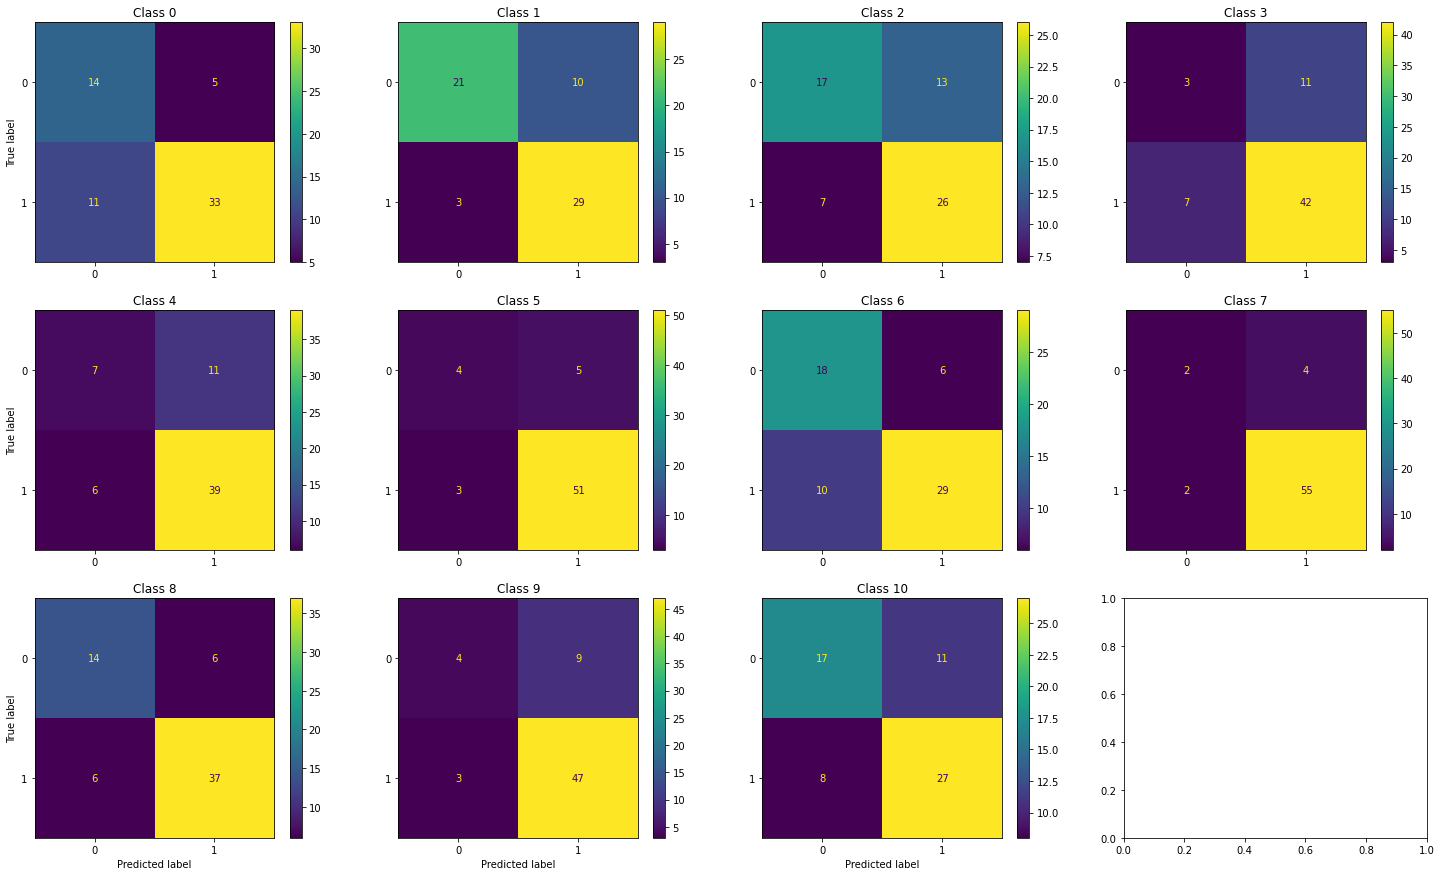

In [ ]:
disp_multilabel_cm(rfc_pred2, 3, 4)

IndexError: single positional indexer is out-of-bounds

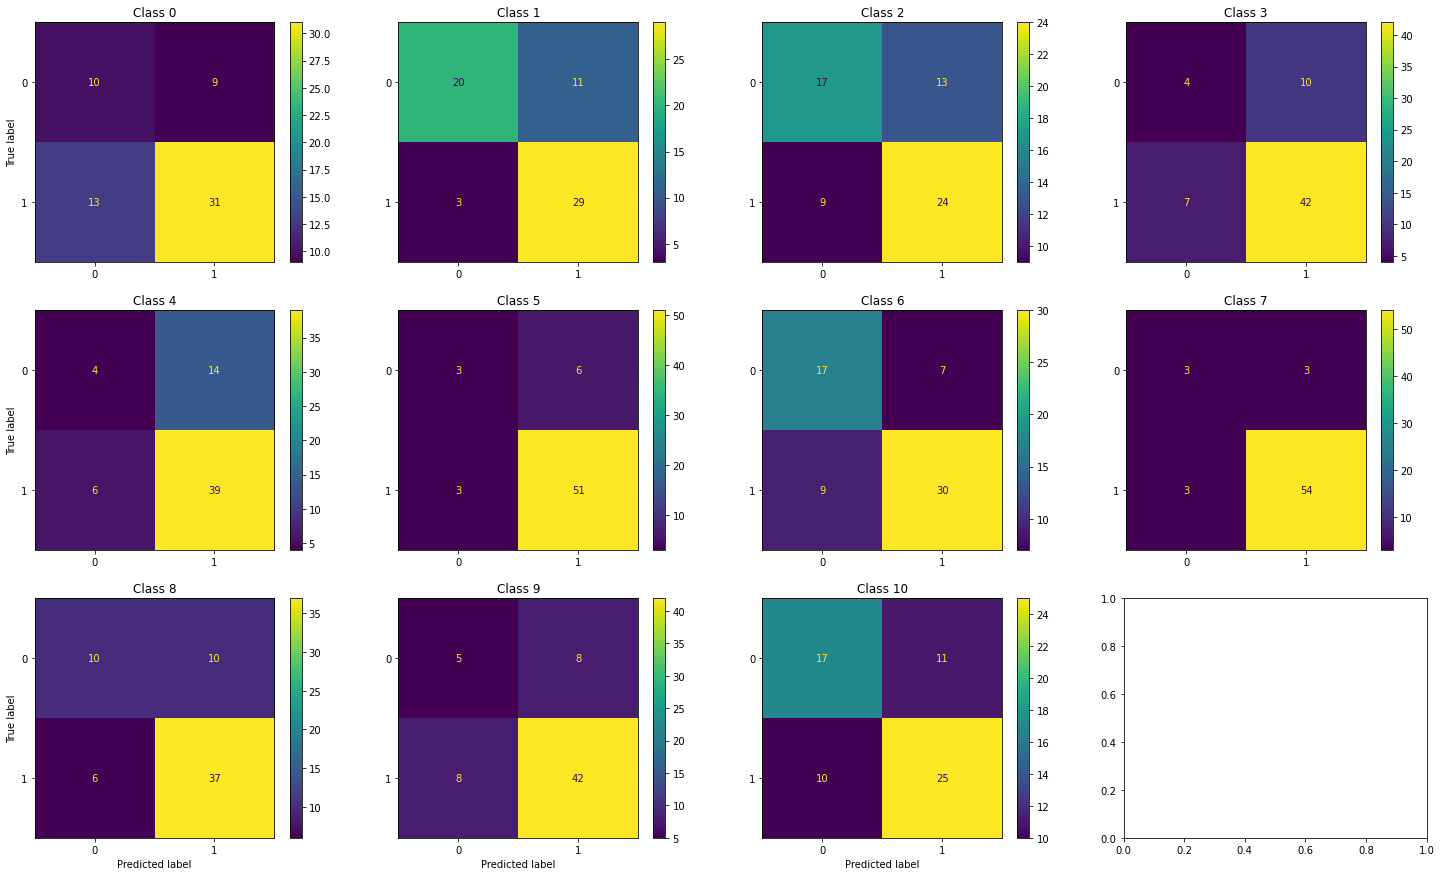

In [ ]:
disp_multilabel_cm(xgb_pred2, 3, 4)

## Export GBC2, RFC2, XGB2

In [ ]:
pickle.dump(gbc2, open("gbc2.sav", "wb"))
pickle.dump(rfc2, open("rfc2.sav", "wb"))
pickle.dump(xgb2, open("xgb2.sav", "wb"))

### Simulated Annealing

In [ ]:
# param_space_rfc = {
#     'n_estimators': [80, 100, 150, 200, 250, 500, 1000, 1500, 2000, 2500, 3000],
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'max_depth': [3, 4, 5, 7, 10, 15, 20],
#     'min_samples_split': [2, 3, 5, 7, 11, 17, 26, 40],
#     'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10, 15, 20],
#     'max_features': ['sqrt', 'log2', None]
# }
   
# # grid = GridSearchCV(RandomForestClassifier(), param_space_rfc, refit = True, verbose = 3,n_jobs=-1) 

In [ ]:
# from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score


# train_scoring = {
#     'accuracy': make_scorer(accuracy_score),
#     'precision': make_scorer(precision_score, average='micro'),
#     'recall': make_scorer(recall_score, average='micro'),
#     'f1_score': make_scorer(f1_score, average='micro'),
#     'roc_auc': make_scorer(roc_auc_score, average='micro'),
#     'hamming_loss': make_scorer(hamming_loss, greater_is_better=False)
# }

In [ ]:
# rfc_sa_best_params, rfc_sa_train_result, rfc_sa_history, rfc_sa_time = simulated_annealing(model=RandomForestClassifier(), 
#                                                                                             param_space=param_space_rfc, 
#                                                                                             max_iter=50, scoring=train_scoring, 
#                                                                                             X=X_train, y=y_train, 
#                                                                                             initial_temp=100, cooling_rate=0.90, cv_times=3, 
#                                                                                             model_type='rfc',
#                                                                                             n_jobs=-1, seed=42)
# print("Best Parameters:", rfc_sa_best_params)
# print("Best Accuracy:", rfc_sa_train_result['mean_accuracy'])
# print("Best Precision:", rfc_sa_train_result['mean_precision'])
# print("Best Recall:", rfc_sa_train_result['mean_recall'])
# print("Best F1 Score:", rfc_sa_train_result['mean_f1'])
# print("Best ROC AUC:", rfc_sa_train_result['mean_roc_auc'])
# print(f"Total time taken: {rfc_sa_time} seconds")

# # plot_score_vs_iterations(rfc_sa_history)

# # rfc_model_sa.set_params(**rfc_sa_best_params)
# # rfc_model_sa.fit(X_train, y_train)

# # y_pred = rfc_model_sa.predict(X_test)
# # y_prob = rfc_model_sa.predict_proba(X_test)[:, 1]

In [ ]:
# %matplotlib inline
# plot_score_vs_iterations(rfc_sa_history)

### GridSearchCV

In [ ]:
# grids = []
# for target in targets:
#   y_this_class = y2_train[target]
#   grids.append(grid.fit(X2_train, y_this_class))
# predicts = []
# for grid in grids:
#   grid_pred = grid.predict(X2_test)
#   predicts.append(grid_pred)
# predicts = np.array(predicts)
# predicts = predicts.flatten()
# predicts = np.transpose(predicts)
# predicts = np.reshape(predicts, (-1, 11))
# # predicts = predicts.flatten()
# # predicts = np.concatenate(predicts, axis = 0)
# print(classification_report(y2_test, predicts))

In [76]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)
np.set_printoptions(threshold=np.inf)